In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import env
import dataprep

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

from sklearn.model_selection import train_test_split

# Predicting Home Values
Ella Xu
Junior Data Scientist | Zillow Data Science Team

# Goals
Zillow has a model that is designed to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017. The goal of this project is to look for insights that can help possibly improve this model, and make recommendations on how to improve it.

# Planning
* Setup my repository environment (.gitignore, README.md)
* Import and test my wrangle functions
* Define an test at least two hypothesis’s
* Train and Evalutate three different classification models.
* Create a csv file with predictions, from the model that perfoms the best
* Report my conclusions and next steps in a presentation.


# Executive Summary
* My OLS Regressor Model had a Root Mean Squared Error (RMSE) of... beating my Baseline RMSE of...

# Acquiring the Data
To acquire the Zillow data, I used the zillow database in the Codeup SQL server, and selected the requested columns. I then selected only Single Family Residential and Inferred Single Family Residential from the 2017 properties using propertylandusetypeid.
    
    
    
    
     SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
     taxvaluedollarcnt, yearbuilt, taxamount, fips FROM properties_2017
     LEFT JOIN propertylandusetype USING(propertylandusetypeid)
     WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")

In [4]:
zillow = dataprep.get_zillow_data()
zillow.head()

Using cached csv


,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


# Cleaning the Data

1. Rename the columns to make it easy to read. 'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built'.

2. Remove outliers from 'bedrooms', 'bathrooms', 'squarefeet', and 'tax_value'.
There were some extremely large houses with 17 bathrooms that I believed would not represent the average Single Family Residential. So I removed these with statistics upper and lower bounds.

3. Replace the null value with median value in year_built columns. Replace 1.75 bathrooms to 2.0 bathrooms count. 


4. Convert column datatypes, year_built and fips to object datatype. 

5. Feature engineering by add a column named home_age, means home years old. 

6. Split the data 80/20 train test split. # 70/30 train validate split

In [6]:
# Import the train, validate and test data from the function we made in dataprep.py
train, validate, test = dataprep.wrangle_zillow()

Using cached csv


In [7]:
print(train.shape)
print(validate.shape)
print(test.shape)
#print out the shape of the train, validate and test to double check. 

(1038959, 8)
(445269, 7)
(371057, 7)


In [8]:
train.head()
#Make sure the columns are all present. 

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,home_age
10057,4.0,2.0,1561.0,248240.0,1973.0,2504.40,6059.0,44.0
2004970,3.0,2.0,1770.0,88390.0,1960.0,1671.93,6037.0,57.0
306031,2.0,1.0,1452.0,81169.0,1946.0,1310.88,6037.0,71.0
1038595,3.0,1.0,1000.0,119174.0,1950.0,1900.28,6037.0,67.0
270959,3.0,2.0,1974.0,432268.0,1988.0,5315.27,6037.0,29.0


In [9]:
train.info()
# Double check the datatype of each columns. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038959 entries, 10057 to 843328
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    1038959 non-null  float64
 1   bathrooms   1038959 non-null  float64
 2   area        1038959 non-null  float64
 3   tax_value   1038959 non-null  float64
 4   year_built  1038959 non-null  float64
 5   taxamount   1038959 non-null  float64
 6   fips        1038959 non-null  object 
 7   home_age    1038959 non-null  float64
dtypes: float64(7), object(1)
memory usage: 71.3+ MB


In [10]:
train.describe()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,home_age
count,1.038959e+06,1.038959e+06,1.038959e+06,1.038959e+06,1.038959e+06,1.038959e+06,1.038959e+06
mean,3.214004e+00,2.053663e+00,1.653719e+03,3.279629e+05,1.959442e+03,4.069177e+03,5.755751e+01
std,7.810489e-01,7.078391e-01,5.642472e+02,1.989876e+05,2.053350e+01,2.242512e+03,2.053350e+01
min,2.000000e+00,1.000000e+00,1.000000e+00,2.200000e+01,1.812000e+03,2.024000e+01,1.000000e+00
25%,3.000000e+00,2.000000e+00,1.232000e+03,1.738435e+05,1.949000e+03,2.366720e+03,4.500000e+01
50%,3.000000e+00,2.000000e+00,1.548000e+03,2.966240e+05,1.957000e+03,3.746240e+03,6.000000e+01
75%,4.000000e+00,2.500000e+00,1.987000e+03,4.525140e+05,1.972000e+03,5.488415e+03,6.800000e+01
max,5.000000e+00,4.000000e+00,3.410000e+03,9.509400e+05,2.016000e+03,1.037770e+04,2.050000e+02


# Explore the Train dataset

## Dataset Overview Questions: 

### What's the distribution of the home values? 

In [11]:
print("The mean of the home values are", round(train.tax_value.mean(),2))
print("The min of the home values are", train.tax_value.min())
print("The max of the home values are",  train.tax_value.max())

The mean of the home values are 327962.93
The min of the home values are 22.0
The max of the home values are 950940.0


<AxesSubplot:xlabel='tax_value'>

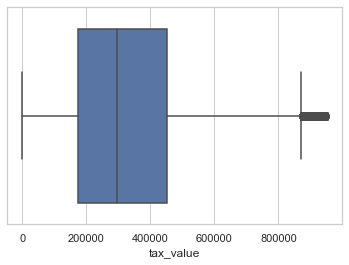

In [12]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=train, x="tax_value")
# The majority of home values are from 0 - 900k, there are a couple outliers which are greater than 900k.

### What's the distribution of the building years? 

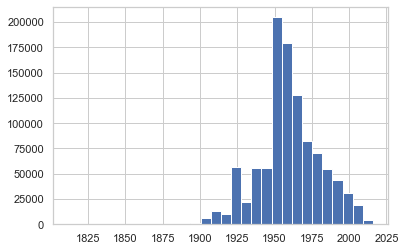

In [40]:
plt.hist(train[['year_built']], bins=30)
plt.show()

The building years hist shows a normal distribution. More than half of homes are built between 1960-1975.

### What's tax_value of homes through the years? 
From the chart below, we have found that from 1900 - 2016 year built homes have higher home values, seems like younger homes have higher tax value. 

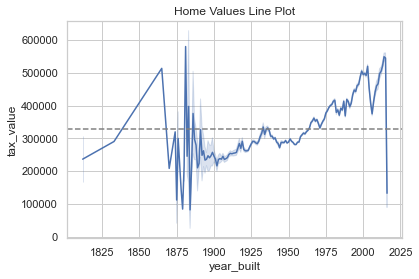

In [13]:
sns.lineplot(x= 'year_built', y= 'tax_value', data= train)
plt.title('Home Values Line Plot')
mean = train.tax_value.mean()
plt.axhline(mean, ls='--', color='grey')
#The grey line is the mean of the all tax_value. 

The distribution of tax_values through years are hard to draw a clue, from 1875-1900, the home values
were up and down, very unstable. However, after 1900, seems younger homes are value more and more. 

### What are two features have strongest relationship with tax_value? 

In [14]:
#first, let's create X_train and y_train for scaling our data. 
X_train = train.drop(columns=['tax_value','fips'])
y_train = train.tax_value

In [15]:
X_train.head()

,bedrooms,bathrooms,area,year_built,taxamount,home_age
10057,4.0,2.0,1561.0,1973.0,2504.40,44.0
2004970,3.0,2.0,1770.0,1960.0,1671.93,57.0
306031,2.0,1.0,1452.0,1946.0,1310.88,71.0
1038595,3.0,1.0,1000.0,1950.0,1900.28,67.0
270959,3.0,2.0,1974.0,1988.0,5315.27,29.0


In [11]:
scaler = sklearn.preprocessing.MinMaxScaler()
#MinMax: everything between 0 and 1
# Fit the scaler, (fit the thing)
scaler.fit(X_train)

# Use the scaler to transform train, validate, test (use the thing)
X_train_scaled = scaler.transform(X_train)

In [12]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
#scaled function only return us a nparray, we will need to convert them into dataframe. 
X_train_scaled.head()

,bedrooms,bathrooms,area,year_built,taxamount,home_age
0,0.666667,0.333333,0.457612,0.789216,0.239843,0.210784
1,0.333333,0.333333,0.518921,0.725490,0.159469,0.274510
2,0.000000,0.000000,0.425638,0.656863,0.124610,0.343137
3,0.333333,0.000000,0.293048,0.676471,0.181516,0.323529
4,0.333333,0.333333,0.578762,0.862745,0.511229,0.137255


***Select K Best***


looks at each feature in isolation against the target based on correlation
fastest of all approaches covered in this lesson
doesn't consider feature interactions

In [13]:
kbest = SelectKBest(f_regression, k=2)
kbest.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7fdc6129a040>)

In [14]:
X_train_scaled.columns[kbest.get_support()]

Index(['area', 'taxamount'], dtype='object')

The select k best get us the best two features are area and ....

***RFE Recursive Feature Elimination***

Progressively eliminate features based on importance to the model
Requires a model with either a .coef_ or .feature_importances_ property

In [15]:
model = LinearRegression() #first, we will create the model. 
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)
# Fit the thing
#transform them into dataframe
X_train_transformed = pd.DataFrame(
    rfe.transform(X_train),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[rfe.support_]
)
X_train_transformed.head()

,year_built,home_age
0,1973.0,44.0
1,1960.0,57.0
2,1946.0,71.0
3,1950.0,67.0
4,1988.0,29.0


In [16]:
# Get list of top K features. 
X_train.columns[rfe.get_support()]

Index(['year_built', 'home_age'], dtype='object')

Recursive Feature Elimination Top Two Features are 

### Are homes with more bedrooms and bathrooms worth more?

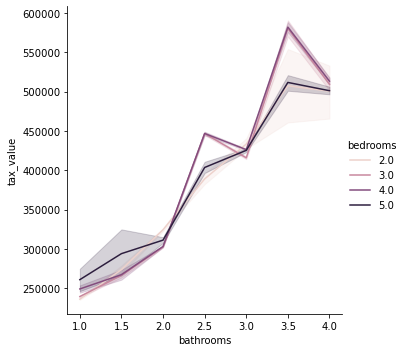

In [20]:
sns.relplot(
    data=train, x="bathrooms", y="tax_value",
    hue="bedrooms", kind="line",
)

### Are homes with bigger area worth more? 

In [29]:
train['home_size'] = ""
train.loc[train.area <= 1600, 'home_size'] = "small"

train.loc[(train.area >1600) &(train.area <= 2300), 'home_size'] = "medium"

train.loc[(train.area >2300) &(train.area <= 3500), 'home_size'] = "large"

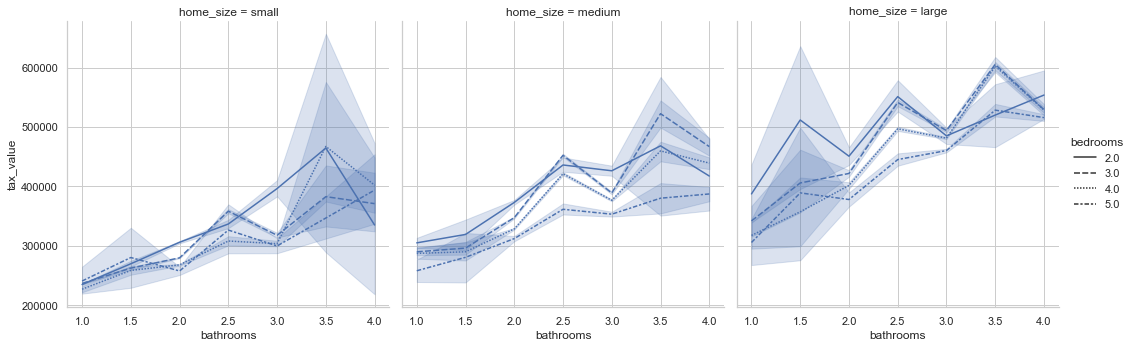

In [32]:
sns.relplot(
    data=train, x="bathrooms", y="tax_value",col = "home_size", style = 'bedrooms',
    kind="line",
)


# Statistical Test Questions: 

### 1. Are homes with more bedrooms worth more?

### 2. Do younger homes worth more? 

In [16]:
alpha = 0.05 #let's assume alpha is 0.05

### 1. Are homes with more bedrooms worth more?
H0: There is no difference in tax_value between homes bedrooms counts vs homes values.

Ha: There is a difference in tax_value between homes bedrooms counts vs homes values.


<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

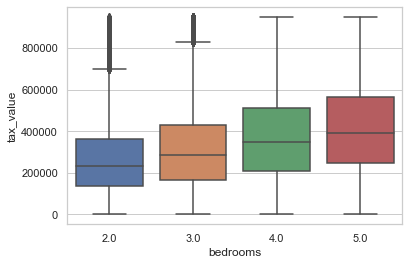

In [34]:
sns.boxplot(x="bedrooms", y="tax_value", data=train)

In [25]:
tax_value_1_2Bd = train[(train.bedrooms == 2) | (train.bedrooms == 3)].tax_value
tax_value_4_5Bd = train[(train.bedrooms == 4) | (train.bedrooms == 5)].tax_value

In [26]:
# Perform a t test becuase we are comparsing two means
t, p = stats.ttest_ind(tax_value_1_2Bd,tax_value_4_5Bd, equal_var=False )
t, p

(-179.15300475202454, 0.0)

### 2. Are younger homes higher in tax_value than old homes?
H0: Home ages have no relationship with tax values 

Ha: Home ages have relationship with tax values 

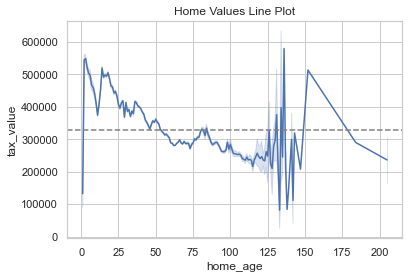

In [27]:
sns.lineplot(x= 'home_age', y= 'tax_value', data= train)
plt.title('Home Values Line Plot')
mean = train.tax_value.mean()
plt.axhline(mean, ls='--', color='grey')
#The grey line is the mean of the all tax_

In [19]:
corr, p = stats.pearsonr(train.home_age, train.tax_value)


corr, p

(-0.24905547411217877, 0.0)

In [44]:
bins = np.linspace(train['year_old'].min(),train['year_old'].max(),10)
bins

bins = np.array([0, 30, 60,90,120,150,180,210])
labels = ["0-30 Years",'30-60 Years' ,'60-90 Years', '90-120 Years','120-150 Years','150-180 Years','180-210 Years']


train["year_old_bin"] = pd.cut(train['year_old'], bins=bins, labels=labels, include_lowest=True)


In [65]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,year_old,year_old_bin
10057,4.0,2.0,1561.0,248240.0,1973.0,2504.40,6059.0,44.0,30-60 Years
2004970,3.0,2.0,1770.0,88390.0,1960.0,1671.93,6037.0,57.0,30-60 Years
306031,2.0,1.0,1452.0,81169.0,1946.0,1310.88,6037.0,71.0,60-90 Years
1038595,3.0,1.0,1000.0,119174.0,1950.0,1900.28,6037.0,67.0,60-90 Years
270959,3.0,2.0,1974.0,432268.0,1988.0,5315.27,6037.0,29.0,0-30 Years


<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

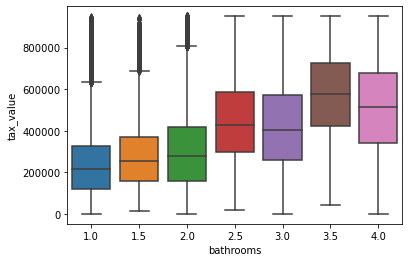

In [10]:
sns.boxplot(x="bathrooms", y="tax_value", data=train)

# Modeling 

# Key Findings 

# Recomandations

# Next Steps